In [2]:
import pandas
import warnings
from matplotlib import pyplot
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis
from deps.data import load_metadata
from deps.logger import logger
from deps.data import load_raw_data, load_data
from hcve_lib.functional import pipe
from hcve_lib.data import to_survival_y_records, get_X, get_survival_y
from hcve_lib.cv import train_test
from hcve_lib.utils import list_to_dict_index
from sklearn.model_selection import KFold
from hcve_lib.cv import cross_validate, predict_survival, lm_cv, kfold_cv
from hcve_lib.evaluation_functions import compute_metrics, c_index
from hcve_lib.cv import lco_cv
from hcve_lib.data import format_identifier_long
from hcve_lib.transformers import MiceForest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

logger.setLevel('DEBUG')
pandas.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
pyplot.rcParams['figure.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
metadata = load_metadata()
data = load_data(metadata)
raw_data = load_raw_data()
raw_data_subset = raw_data.loc[data.index]

Raw data
	n cohorts=21
	n individuals=52,585

INFO:homage_fl:Raw data
	n cohorts=21
	n individuals=52,585

Baseline visit kept
 	n individuals removed=5,529

 	n individuals=47,056

INFO:homage_fl:Baseline visit kept
 	n individuals removed=5,529

 	n individuals=47,056

HF cohorts removed
	n cohorts removed=3: hfgr, timechf, leitzaran
	n individuals removed=1,073

	n cohorts=18
	n individuals=45,983

INFO:homage_fl:HF cohorts removed
	n cohorts removed=3: hfgr, timechf, leitzaran
	n individuals removed=1,073

	n cohorts=18
	n individuals=45,983

No outcome cohorts removed
	n cohorts removed=5: biomarcoeurs, dyda, epath, iblomaved, stophf
	n individuals removed=3,077

	n cohorts=13
	n individuals=42,906

INFO:homage_fl:No outcome cohorts removed
	n cohorts removed=5: biomarcoeurs, dyda, epath, iblomaved, stophf
	n individuals removed=3,077

	n cohorts=13
	n individuals=42,906

Missing HF data cohorts removed
	n cohorts removed=6: adelhyde, gecoh, r2c2, reve(1-2), stanislas, styrianvitd

In [ ]:
for column in data.columns:
    print(f'{len(data[column].unique())}: {format_identifier_long(column, metadata)}')

In [ ]:
for column in data.columns:
    if len(data[column].unique()) < 10:
        data.loc[:, column] = data[column].astype('category')
    print(f'{data[column].dtype}: {format_identifier_long(column, metadata)}')

In [38]:
import pickle

with open('./data/prediction.data', 'rb') as file:
    results = pickle.load(file)

Text(0.5, 0, 'Fold')

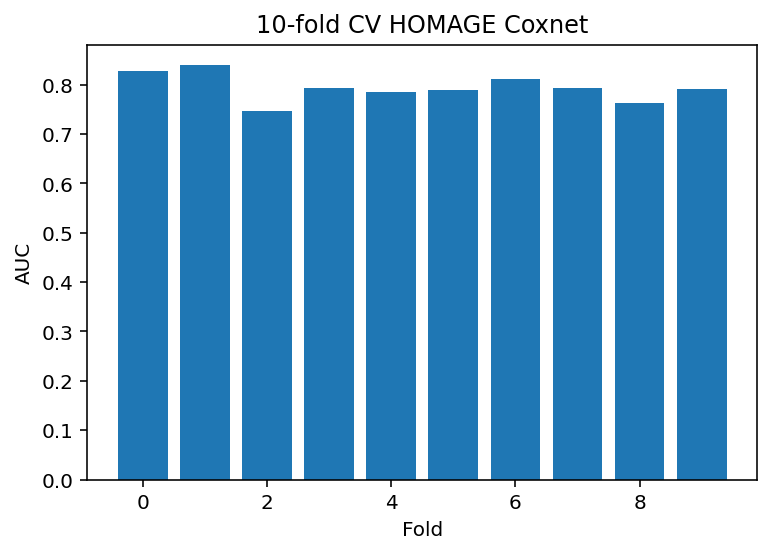

In [104]:
from matplotlib.ticker import MaxNLocator

pyplot.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
pyplot.title('10-fold CV HOMAGE Coxnet')
pyplot.bar(range(len(results)),[item['c_index'] for item in results.values()])
pyplot.ylabel('AUC')
pyplot.xlabel('Fold')